In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [5]:
workspace = r"C:\Users\gev37\OneDrive - Texas State University\Thesis\data/"

In [18]:
df_raw = pd.read_csv(
    workspace + "0 raw/mobility_phoenix/od_flow-visitor_home_cbgs-poi_cbg-Maricopa_Pinal_County-2023-01-02_2023-12-25.csv.gz",
    compression="gzip"
)

# Filter data for summer period (June 5 – August 28, 2023)
df_raw["date_range_start"] = pd.to_datetime(df_raw["date_range_start"])
df = df_raw[
    (df_raw["date_range_start"] >= "2023-06-01") &
    (df_raw["date_range_start"] <= "2023-08-28")
]

df.loc[:, "visitor_home_cbgs"] = df["visitor_home_cbgs"].astype(str)
df.loc[:, "poi_cbg"] = df["poi_cbg"].astype(str)

cbg = gpd.read_file(workspace + "1 processed/boundary/phoenix_boundary.shp")
cbg["GEOID"] = cbg["GEOID"].str[1:]

# Filter df_raw so both home and POI CBGs exist in cbg
df = df[
    df["visitor_home_cbgs"].isin(cbg["GEOID"]) &
    df["poi_cbg"].isin(cbg["GEOID"])
] # 717713 rows

C:\Users\gev37\AppData\Local\Temp\ipykernel_14504\3681803695.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['40130101011' '40130101011' '40130101011' ... '40219414005' '40219414005'
 '40219414005']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "visitor_home_cbgs"] = df["visitor_home_cbgs"].astype(str)
C:\Users\gev37\AppData\Local\Temp\ipykernel_14504\3681803695.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['40130101011' '40130101012' '40130101021' ... '40210017031' '40210017061'
 '40219414004']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, "poi_cbg"] = df["poi_cbg"].astype(str)


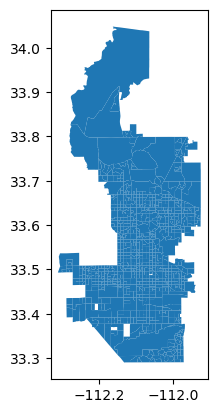

In [10]:
cbg = gpd.read_file(workspace + "1 processed/boundary/phoenix_boundary.shp")
cbg["GEOID"] = cbg["GEOID"].str[1:]  # align with GEOID format

cbg.plot()
plt.show()

# Mobility only

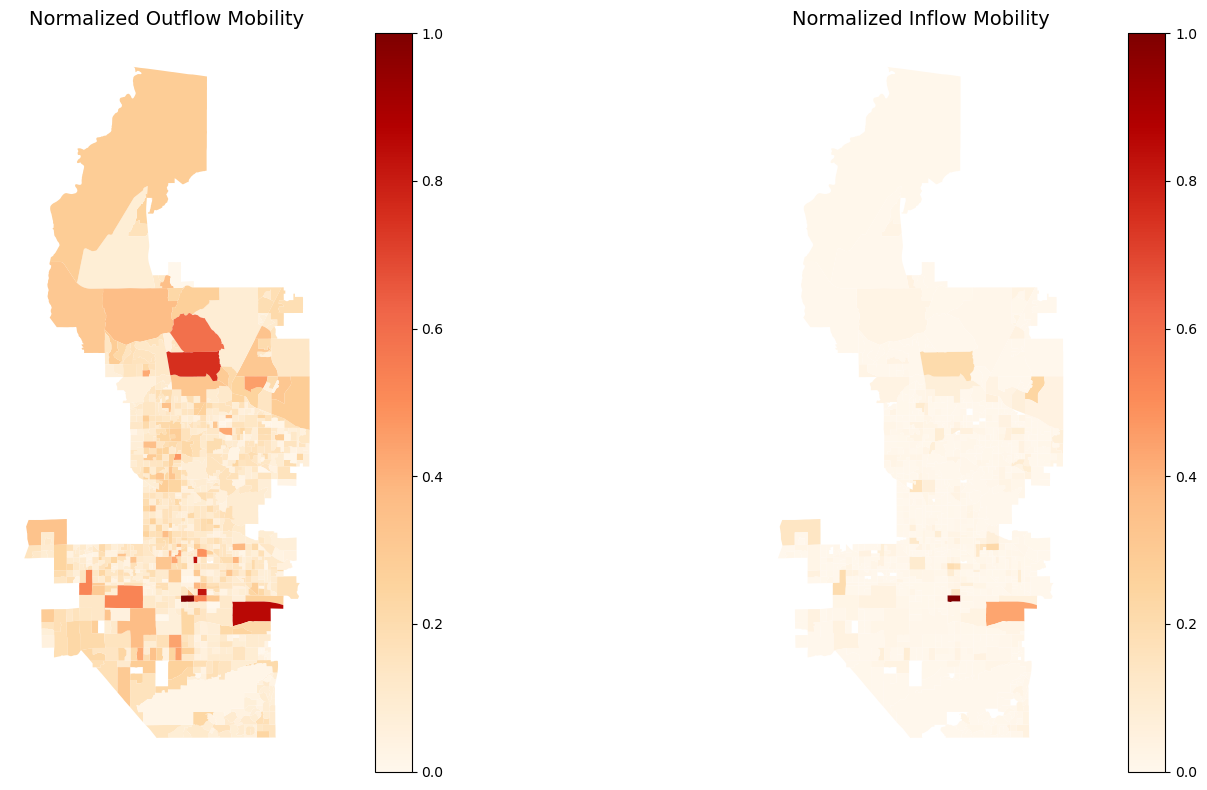

In [23]:
# ------------------------------------------------------------------------------
# 1. Filter only outflow records (exclude self-flows)
# ------------------------------------------------------------------------------
flow_df = df[df['visitor_home_cbgs'] != df['poi_cbg']]

# ------------------------------------------------------------------------------
# 2. Calculate total outflow per home CBG
# ------------------------------------------------------------------------------
outflow_sum = (
    flow_df.groupby('visitor_home_cbgs')['visitor']
    .sum()
    .reset_index(name='outflow')
)

# Normalize outflow values
outflow_sum['outflow_norm'] = (
    (outflow_sum['outflow'] - outflow_sum['outflow'].min()) /
    (outflow_sum['outflow'].max() - outflow_sum['outflow'].min())
)

# Merge with CBG geometry
cbg_out = cbg.merge(
    outflow_sum,
    how='left',
    left_on='GEOID',
    right_on='visitor_home_cbgs'
)

# ------------------------------------------------------------------------------
# 3. Calculate total inflow per POI CBG
# ------------------------------------------------------------------------------
inflow_sum = (
    flow_df.groupby('poi_cbg')['visitor']
    .sum()
    .reset_index(name='inflow')
)

# Normalize inflow values
inflow_sum['inflow_norm'] = (
    (inflow_sum['inflow'] - inflow_sum['inflow'].min()) /
    (inflow_sum['inflow'].max() - inflow_sum['inflow'].min())
)

# Merge with CBG geometry
cbg_in = cbg.merge(
    inflow_sum,
    how='left',
    left_on='GEOID',
    right_on='poi_cbg'
)

# ------------------------------------------------------------------------------
# 4. Plot inflow and outflow side by side
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Outflow map
cbg_out.plot(
    column='outflow_norm',
    cmap='OrRd',
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Normalized Outflow Mobility", fontsize=14)
axes[0].axis('off')

# Inflow map
cbg_in.plot(
    column='inflow_norm',
    cmap='OrRd',
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Normalized Inflow Mobility", fontsize=14)
axes[1].axis('off')

plt.tight_layout()

# ------------------------------------------------------------------------------
# 5. Save the figure
# ------------------------------------------------------------------------------
output_path = f"{workspace}/inflow_outflow_mobility.png"
plt.savefig(
    output_path,
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()

# Mobility with heat

## LST

In [24]:
lst = pd.read_csv(workspace + "1 processed/image/aggregated_lst.csv")
lst.loc[:, "GEOID"] = lst["GEOID"].astype(str)

lst["K_MEAN"] = lst["MEAN"]                   # keep Kelvin
lst["MEAN"] = lst["MEAN"] - 273.15            # convert to Celsius
lst["MEAN_GROUP"] = pd.qcut(lst["MEAN"], q=3, labels=["Low", "Median", "High"]) # 901 CBGs each

# Merge mobility with LST (home & poi)
df_lst = df.merge(
    lst[["GEOID", "MEAN", "MEAN_GROUP"]].rename(columns={"GEOID": "home_cbg", "MEAN": "home_lst", "MEAN_GROUP": "home_heat"}),
    left_on="visitor_home_cbgs",
    right_on="home_cbg",
    how="left"
)
df_lst = df_lst.merge(
    lst[["GEOID", "MEAN", "MEAN_GROUP"]].rename(columns={"GEOID": "poi_cbg", "MEAN": "poi_lst", "MEAN_GROUP": "poi_heat"}),
    left_on="poi_cbg",
    right_on="poi_cbg",
    how="left"
)
df_lst = df_lst.rename(columns={"date_range_start": "date"})

# Create mobility category (e.g., HH, HL, etc.)
df_lst["mobility"] = df_lst["home_heat"].str[0] + df_lst["poi_heat"].str[0]

# Heat vs Non-heat comparison (top 10% vs bottom 10%)
threshold_heat = lst["MEAN"].quantile(0.9)
threshold_nonheat = lst["MEAN"].quantile(0.1)
df_heat = df_lst[df_lst["home_lst"] >= threshold_heat]       # 327,518 rows
df_nonheat = df_lst[df_lst["home_lst"] <= threshold_nonheat] # 259,997 rows

# Define heat and non-heat groups
threshold_heat = lst["MEAN"].quantile(0.9)
threshold_nonheat = lst["MEAN"].quantile(0.1)

df_heat = df_lst[df_lst["home_lst"] >= threshold_heat]
df_nonheat = df_lst[df_lst["home_lst"] <= threshold_nonheat]

C:\Users\gev37\AppData\Local\Temp\ipykernel_14504\43805718.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['40132168291' '40131104003' '40131104004' ... '40131126012' '40136130001'
 '40130405023']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lst.loc[:, "GEOID"] = lst["GEOID"].astype(str)


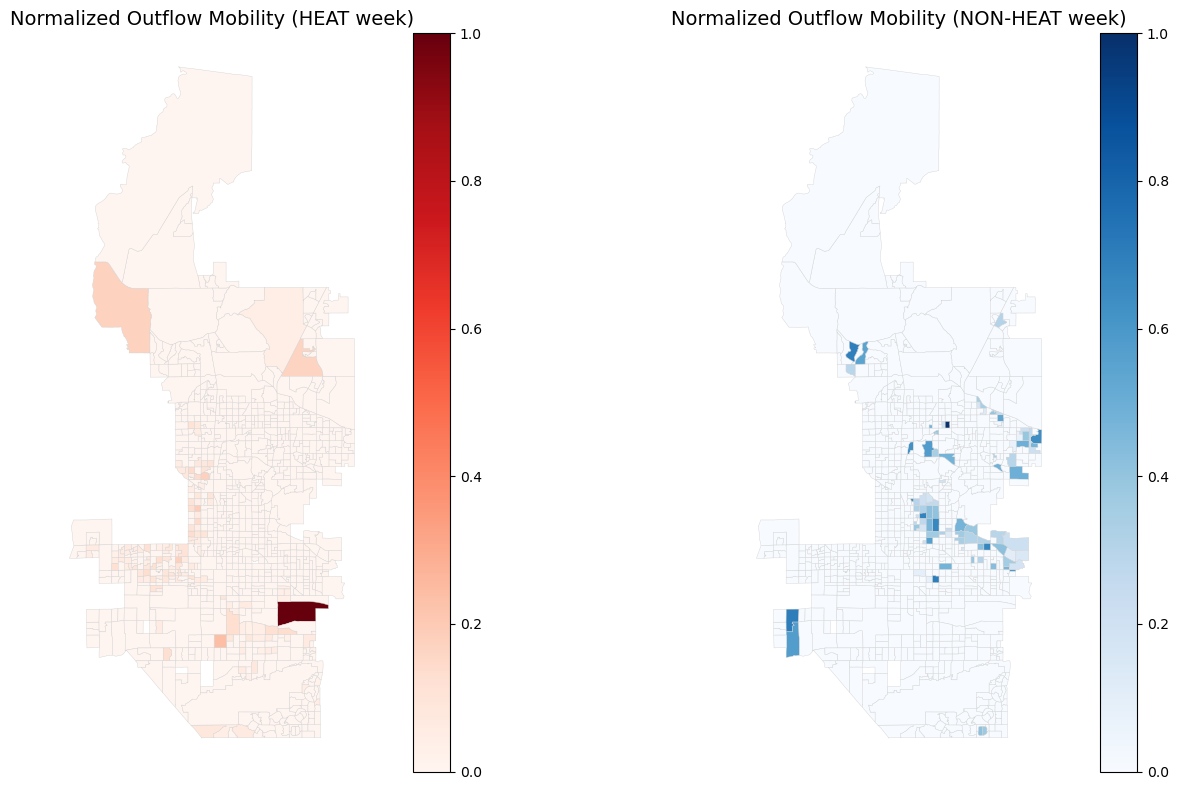

In [25]:
# Summarize and normalize mobility data
# Aggregate total visitors by home CBG
heat_outflow = (
    df_heat.groupby('visitor_home_cbgs')['visitor']
    .sum()
    .reset_index(name='visitor')
)
nonheat_outflow = (
    df_nonheat.groupby('visitor_home_cbgs')['visitor']
    .sum()
    .reset_index(name='visitor')
)

# Min-max normalization (0–1)
heat_outflow['nor_mobility'] = (
    (heat_outflow['visitor'] - heat_outflow['visitor'].min()) /
    (heat_outflow['visitor'].max() - heat_outflow['visitor'].min())
)
nonheat_outflow['nor_mobility'] = (
    (nonheat_outflow['visitor'] - nonheat_outflow['visitor'].min()) /
    (nonheat_outflow['visitor'].max() - nonheat_outflow['visitor'].min())
)

# Join with CBG shapefile
cbg_heat = cbg.merge(heat_outflow, how='left', left_on='GEOID', right_on='visitor_home_cbgs')
cbg_nonheat = cbg.merge(nonheat_outflow, how='left', left_on='GEOID', right_on='visitor_home_cbgs')

# Fill missing values with 0
cbg_heat['nor_mobility'] = cbg_heat['nor_mobility'].fillna(0)
cbg_nonheat['nor_mobility'] = cbg_nonheat['nor_mobility'].fillna(0)

# --------------------------------------------------------------------
# Visualization
# --------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# HEAT map
cbg_heat.plot(
    column='nor_mobility',
    cmap='Reds',
    legend=True,
    ax=axes[0],
    edgecolor='lightgray',   # light gray border
    linewidth=0.3            # thin outline
)
axes[0].set_title('Normalized Outflow Mobility (HEAT week)', fontsize=14)
axes[0].axis('off')

# NON-HEAT map
cbg_nonheat.plot(
    column='nor_mobility',
    cmap='Blues',
    legend=True,
    ax=axes[1],
    edgecolor='lightgray',   # light gray border
    linewidth=0.3
)
axes[1].set_title('Normalized Outflow Mobility (NON-HEAT week)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.savefig(workspace + "outflow_mobility_heat_comparison.png",
            dpi=300,           # high resolution (good for publication)
            bbox_inches='tight', # remove extra whitespace
            facecolor='white')   # ensure background is white
plt.show()

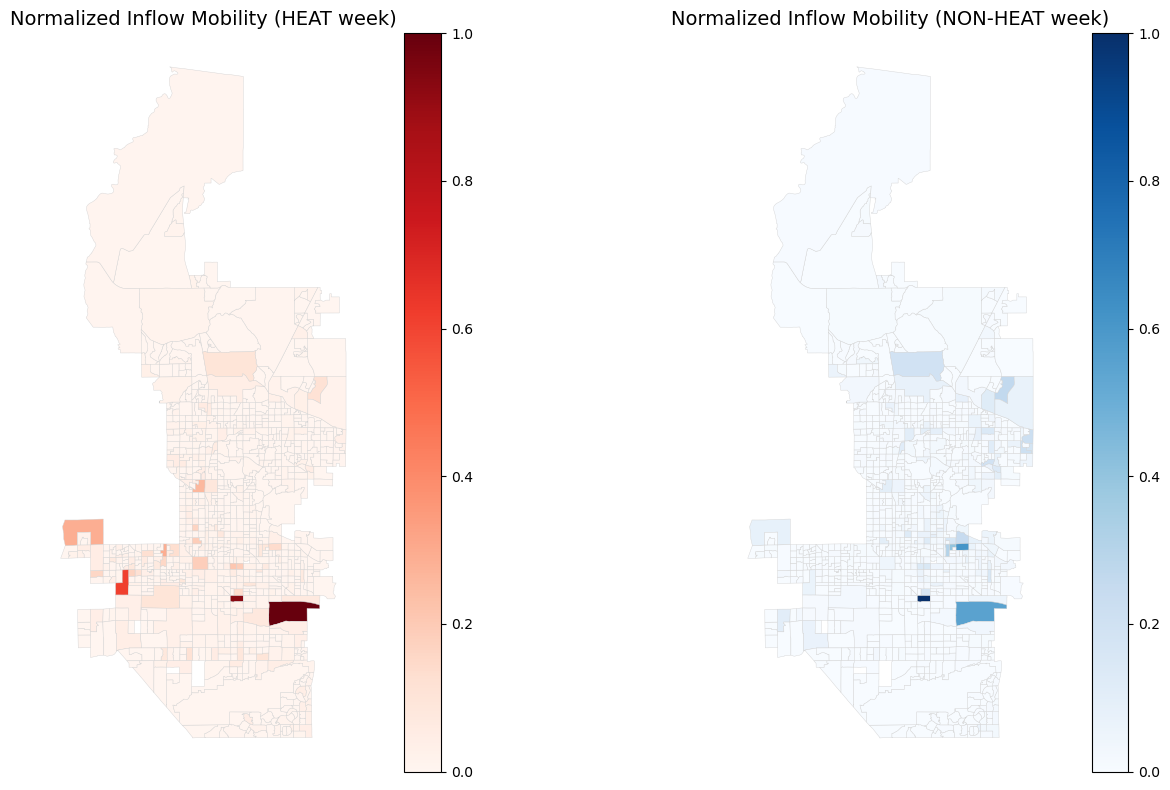

In [26]:
# Aggregate total visitors by POI CBG (inflow)
heat_inflow = (
    df_heat.groupby('poi_cbg')['visitor']
    .sum()
    .reset_index(name='visitor')
)
nonheat_inflow = (
    df_nonheat.groupby('poi_cbg')['visitor']
    .sum()
    .reset_index(name='visitor')
)

# Min-max normalization (0–1)
heat_inflow['nor_mobility'] = (
    (heat_inflow['visitor'] - heat_inflow['visitor'].min()) /
    (heat_inflow['visitor'].max() - heat_inflow['visitor'].min())
)
nonheat_inflow['nor_mobility'] = (
    (nonheat_inflow['visitor'] - nonheat_inflow['visitor'].min()) /
    (nonheat_inflow['visitor'].max() - nonheat_inflow['visitor'].min())
)

# Join with CBG shapefile
cbg_heat_in = cbg.merge(
    heat_inflow,
    how='left',
    left_on='GEOID',
    right_on='poi_cbg'
)
cbg_nonheat_in = cbg.merge(
    nonheat_inflow,
    how='left',
    left_on='GEOID',
    right_on='poi_cbg'
)

# Fill missing normalized values with 0
cbg_heat_in['nor_mobility'] = cbg_heat_in['nor_mobility'].fillna(0)
cbg_nonheat_in['nor_mobility'] = cbg_nonheat_in['nor_mobility'].fillna(0)

# --------------------------------------------------------------------
# Visualization
# --------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# HEAT inflow map
cbg_heat_in.plot(
    column='nor_mobility',
    cmap='Reds',
    legend=True,
    ax=axes[0],
    edgecolor='lightgray',
    linewidth=0.3
)
axes[0].set_title('Normalized Inflow Mobility (HEAT week)', fontsize=14)
axes[0].axis('off')

# NON-HEAT inflow map
cbg_nonheat_in.plot(
    column='nor_mobility',
    cmap='Blues',
    legend=True,
    ax=axes[1],
    edgecolor='lightgray',
    linewidth=0.3
)
axes[1].set_title('Normalized Inflow Mobility (NON-HEAT week)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()

# Save the figure
plt.savefig(
    workspace + "inflow_mobility_heat_comparison.png",
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()